# 👀 How does a LLM see?

This notebook goes along side the blog post on [LLM vision](https://latenttime.com/blog/llm-vision)

In [2]:
%pip install torch transformers Pillow requests matplotlib seaborn scikit-learn --quiet

You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch

/Users/stephenhibbert/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/stephenhibbert/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [8]:
url = 'https://github.com/latenttime/blog/blob/main/public/static/images/lionfish.jpg?raw=true'
image = Image.open(requests.get(url, stream=True).raw)
image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x173244B20>


In [5]:

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: lionfish


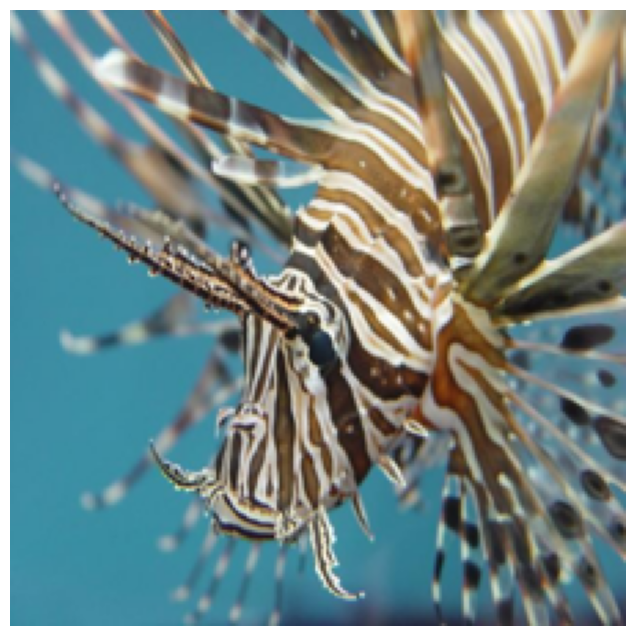

In [6]:
# The pipeline resizes the input image to the size expected by the model - which is 224x224. Let's do this manually
# before digging further under the hood.

image = image.resize((224, 224))
# Display the image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')  # Hide the axes

# Save the image using matplotlib
plt.savefig('lionfish_resized.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

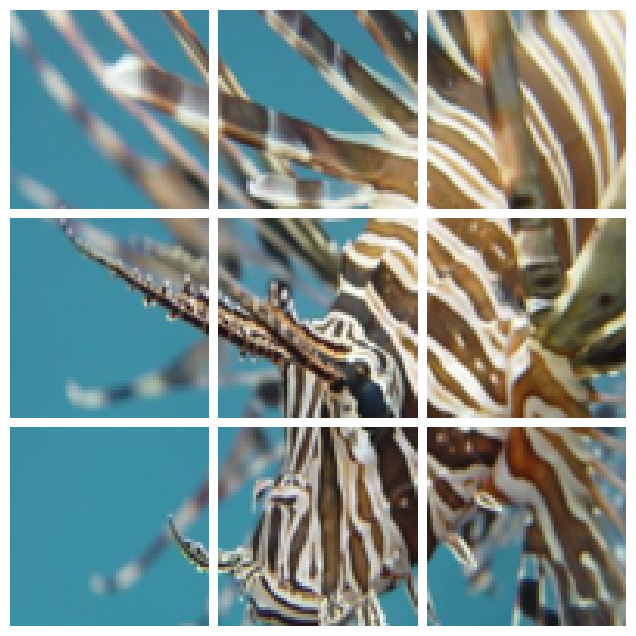

In [7]:
# Visualization of the patches
patch_size = 64  # Size of the patches
num_patches_x = image.size[0] // patch_size
num_patches_y = image.size[1] // patch_size
margin = 3  # Space between patches

# Create a blank canvas with spaces between patches
canvas_width = num_patches_x * (patch_size + margin) - margin
canvas_height = num_patches_y * (patch_size + margin) - margin
canvas = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

# Extract and place each patch onto the canvas
for i in range(num_patches_y):
    for j in range(num_patches_x):
        patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
        canvas.paste(patch, (j * (patch_size + margin), i * (patch_size + margin)))

# Display the image with patches
plt.figure(figsize=(10, 8))
plt.imshow(canvas)
plt.axis('off')  # Hide the axes
plt.savefig('patch_grid.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

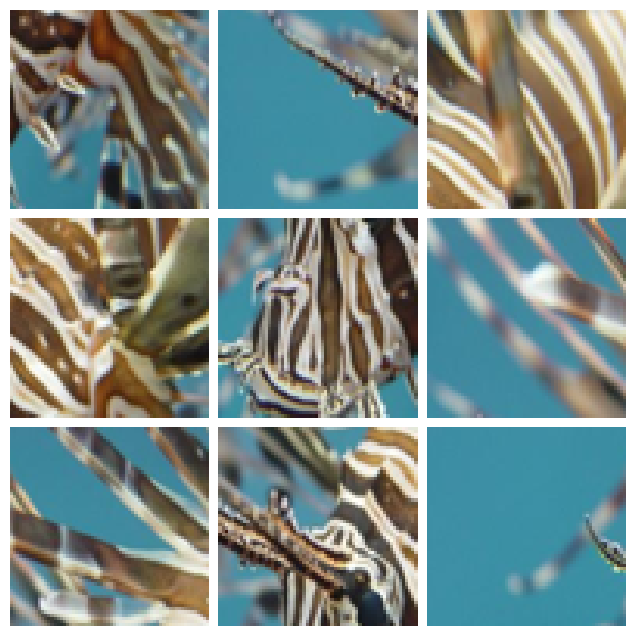

In [8]:
import random

# Visualization of the patches
patch_size = 64  # Size of the patches
num_patches_x = image.size[0] // patch_size
num_patches_y = image.size[1] // patch_size
margin = 3  # Space between patches

# Create a blank canvas with spaces between patches
canvas_width = num_patches_x * (patch_size + margin) - margin
canvas_height = num_patches_y * (patch_size + margin) - margin
canvas = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

# Extract patches
patches = []
for i in range(num_patches_y):
    for j in range(num_patches_x):
        patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
        patches.append(patch)

# Randomly shuffle the patches
random.shuffle(patches)

# Place shuffled patches onto the canvas
for idx, patch in enumerate(patches):
    row = idx // num_patches_x
    col = idx % num_patches_x
    canvas.paste(patch, (col * (patch_size + margin), row * (patch_size + margin)))

# Display the image with patches
plt.figure(figsize=(10, 8))
plt.imshow(canvas)
plt.axis('off')  # Hide the axes
plt.savefig('patch_grid_reordered.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

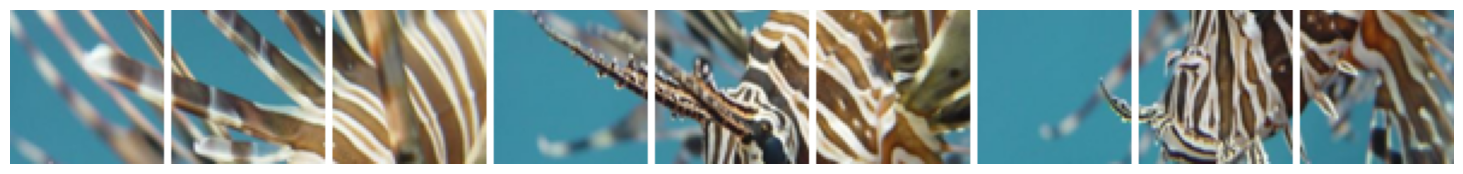

In [9]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Assuming 'image' is already loaded somewhere in your code
# Visualization of the patches
num_patches_x = image.size[0] // patch_size
num_patches_y = image.size[1] // patch_size
margin = 3  # Space between patches

# Instead of creating a canvas for a grid, create a long horizontal canvas
total_patches = num_patches_x * num_patches_y
canvas_width = total_patches * (patch_size + margin) - margin
canvas_height = patch_size  # Only one row of patches
canvas = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

# Create an ImageDraw object to draw text
draw = ImageDraw.Draw(canvas)

# Extract and place each patch onto the canvas and add a number in a single line
patch_number = 0
for i in range(num_patches_y):
    for j in range(num_patches_x):
        patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
        # Compute the position of the patch in the horizontal line
        patch_x = patch_number * (patch_size + margin)
        canvas.paste(patch, (patch_x, 0))
        # Calculate the position for the text to be roughly in the center
        patch_number += 1

# Display the image with patches in a line
plt.figure(figsize=(20, 2))  # Adjusted figure size for better view of the line
plt.imshow(canvas)
plt.axis('off')  # Hide the axes
plt.savefig('patch_num_line.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()


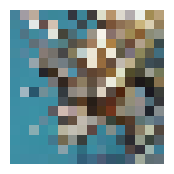

In [20]:
# Choose a patch from somewhere in the middle
middle_x = num_patches_x // 2
middle_y = num_patches_y // 2
patch = image.crop((middle_x * patch_size, middle_y * patch_size, 
                    (middle_x + 1) * patch_size, (middle_y + 1) * patch_size))

# Resize the image to 16x16 pixels
pixelated_image = image.resize((16, 16), Image.NEAREST)

# Display the selected patch
plt.figure(figsize=(2, 2))  # Adjust figure size to better visualize the small patch
plt.imshow(pixelated_image)
plt.axis('off')  # Hide the axes
plt.savefig('patch_single.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

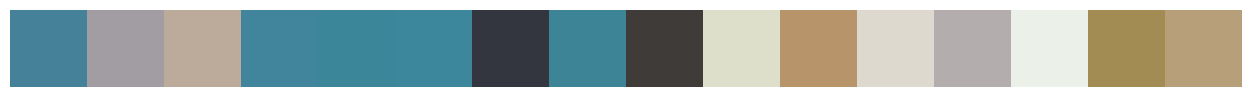

In [62]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Resize the image to 16x16 pixels
pixelated_image = image.resize((16, 16), Image.NEAREST)

# Extract the first row of pixels
pixels = np.array(pixelated_image)
first_row_pixels = pixels[0]

# Create a new image from the first row of pixels
first_row_image = Image.fromarray(first_row_pixels.reshape((1, 16, 3)).astype('uint8'), 'RGB')

# Display the first row image
plt.figure(figsize=(16, 1))  # Adjust figure size to better visualize the first row image
plt.imshow(first_row_image)
plt.axis('off')  # Hide the axes
plt.savefig('first_row_pixels.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()


In [56]:
first_row_pixels.shape

(16, 3)

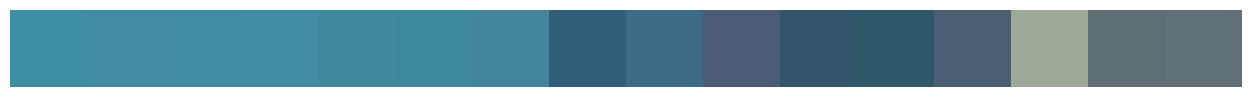

In [48]:
last_row_pixels = pixels[-1]

# Create a new image from the first row of pixels
last_row_image = Image.fromarray(last_row_pixels.reshape((1, 16, 3)).astype('uint8'), 'RGB')

# Display the first row image
plt.figure(figsize=(16, 1))  # Adjust figure size to better visualize the first row image
plt.imshow(last_row_image)
plt.axis('off')  # Hide the axes
plt.savefig('last_row_pixels.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()


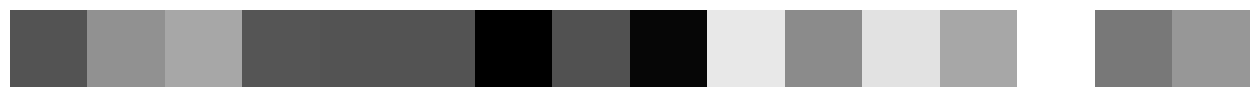

In [68]:
# Convert the RGB values of the first row to grayscale
# Grayscale conversion using the formula: 0.299 * R + 0.587 * G + 0.114 * B
grayscale_values = np.dot(first_row_pixels, [0.299, 0.587, 0.114])

# Create a new image from the grayscale values
grayscale_image = Image.fromarray(grayscale_values.reshape((1, 16)).astype('uint8'), 'L')

# Display the grayscale image
plt.figure(figsize=(16, 1))  # Adjust figure size to better visualize the grayscale image
plt.imshow(grayscale_image, cmap='gray', aspect='auto')
plt.axis('off')  # Hide the axes
plt.savefig('first_row_grayscale.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

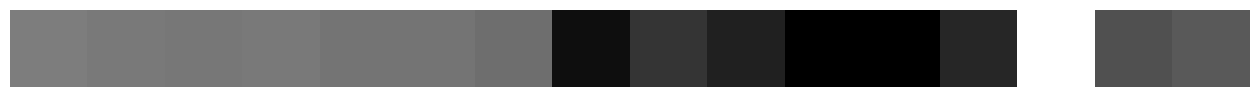

In [69]:
# Convert the RGB values of the last row to grayscale
# Grayscale conversion using the formula: 0.299 * R + 0.587 * G + 0.114 * B
grayscale_values = np.dot(last_row_pixels, [0.299, 0.587, 0.114])

# Create a new image from the grayscale values
grayscale_image = Image.fromarray(grayscale_values.reshape((1, 16)).astype('uint8'), 'L')

# Display the grayscale image
plt.figure(figsize=(16, 1))  # Adjust figure size to better visualize the grayscale image
plt.imshow(grayscale_image, cmap='gray', aspect='auto')
plt.axis('off')  # Hide the axes
plt.savefig('last_row_grayscale.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

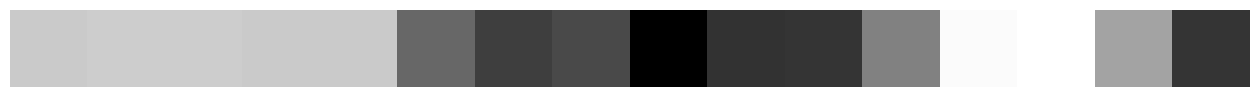

In [84]:
# Resize the image to 16x16 pixels
pixelated_image = image.resize((16, 16), Image.NEAREST)

# Extract the first row of pixels
pixels = np.array(pixelated_image)
first_row_pixels = pixels[9]

# Convert the RGB values of the last row to grayscale
# Grayscale conversion using the formula: 0.299 * R + 0.587 * G + 0.114 * B
grayscale_values = np.dot(first_row_pixels, [0.299, 0.587, 0.114])

# Create a new image from the grayscale values
grayscale_image = Image.fromarray(grayscale_values.reshape((1, 16)).astype('uint8'), 'L')

# Display the grayscale image
plt.figure(figsize=(16, 1))  # Adjust figure size to better visualize the grayscale image
plt.imshow(grayscale_image, cmap='gray', aspect='auto')
plt.axis('off')  # Hide the axes
plt.savefig('random_grayscale.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

In [ ]:
# Convert the RGB values of the first row to grayscale
# Grayscale conversion using the formula: 0.299 * R + 0.587 * G + 0.114 * B
grayscale_values = np.dot(first_row_pixels, [0.299, 0.587, 0.114])

# Create a new image from the grayscale values
grayscale_image = Image.fromarray(grayscale_values.reshape((1, 16)).astype('uint8'), 'L')

# Display the grayscale image
plt.figure(figsize=(16, 1))  # Adjust figure size to better visualize the grayscale image
plt.imshow(grayscale_image, cmap='gray', aspect='auto')
plt.axis('off')  # Hide the axes
plt.savefig('first_row_grayscale.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save as PNG with high resolution
plt.show()

In [46]:
first_row_pixels
first_pixel_rgb = tuple(first_row_pixels[0])
first_pixel_rgb

(69, 130, 154)

In [60]:
# Normalize the RGB values
normalized_rgb = tuple([value / 255.0 for value in first_pixel_rgb])
normalized_rgb

(0.27058823529411763, 0.5098039215686274, 0.6039215686274509)

In [11]:
# Convert the patch to tensor and normalize
patch_tensor = processor(images=patch, return_tensors="pt").pixel_values
patch_embedded = model.vit.embeddings.patch_embeddings(patch_tensor)
print(patch_embedded.shape)
print(patch_tensor.shape)

# Batch size: 1
# Image width/height: 224 (dictated by model)
# Number of channels: 3 (RGB)
# Patch size: 16x16
# Number of patches: 196 (14 x 14)

torch.Size([1, 196, 768])
torch.Size([1, 3, 224, 224])


These embeddings are subsequently used as the input sequence for the Transformer's encoder. Each embedding vector is treated similarly to a token embedding in NLP tasks, where each patch embedding represents part of the image information, analogous to how each word embedding would represent part of the semantic information in a text processing task. The model then processes these embeddings, considering both individual features and interactions between patches (through self-attention mechanisms), to understand and classify the image or perform other vision tasks.

In [12]:
patch_size = 16 # Reset to the real patch size of the model

img_width, img_height = image.size
num_patches_x, num_patches_y = img_width // patch_size, img_height // patch_size

print(num_patches_x, num_patches_y)

patches = []
for i in range(num_patches_y):
    for j in range(num_patches_x):
        # Extract patch
        patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
        patches.append(patch)

# Process patch
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
# embeddings = outputs.hidden_states[-1][:, 0, :]  # Get the CLS token's embeddings

14 14


In [13]:
outputs.attentions[2].shape

torch.Size([1, 12, 197, 197])

In [87]:
def get_patch_embeddings_for_layer(hidden_layer = 0):
    patch_embeddings = []
    # Iterate through the length of patches
    for idx in range(len(patches)):
        embeddings = outputs.hidden_states[hidden_layer][:, idx, :]  # Get the hidden state's embeddings
        patch_embeddings.append(embeddings.squeeze(0))  # Squeeze to remove batch dimension and append
    return patch_embeddings

In [88]:
first_layer = get_patch_embeddings_for_layer()
first_layer[0][0:3]

tensor([ 0.0195,  0.0298, -0.5341])

In [15]:
%pip install imageio pygifsicle --quiet

Note: you may need to restart the kernel to use updated packages.


In [16]:
import torch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
import imageio

def plot_patch_embeddings(patches, num_layers):
    frames = []
    for hidden_layer in range(num_layers):
        patch_embeddings = get_patch_embeddings_for_layer(hidden_layer)
        embeddings = torch.stack([emb.squeeze() for emb in patch_embeddings])

        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(embeddings.detach().numpy())

        fig, ax = plt.subplots()
        for (x, y), patch in zip(principal_components, patches):
            imgbox = OffsetImage(patch, zoom=0.5)
            ab = AnnotationBbox(imgbox, (x, y), frameon=False, pad=0.1)
            ax.add_artist(ab)

        ax.update_datalim(principal_components)
        ax.autoscale()
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'PCA of Patch Embeddings - Layer {hidden_layer}')

        # Save the plot to a PNG file
        filename = f'layer_{hidden_layer}.png'
        plt.savefig(filename, format='png', dpi=300)
        plt.close(fig)
        frames.append(imageio.imread(filename))

    # Create a GIF
    imageio.mimsave('patch_embeddings_pca.gif', frames, duration=int(1000 * 1/1), loop=0)

# Example usage
# Assuming `model` is loaded and `patches` are prepared (images must be loaded as small patches)
# and `num_layers` is the total number of layers in the model
plot_patch_embeddings(patches, 12)


/var/folders/0j/wldqq7q1615fqxmyx_zwp5lr0000gn/T/ipykernel_18607/4278122939.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))
/var/folders/0j/wldqq7q1615fqxmyx_zwp5lr0000gn/T/ipykernel_18607/4278122939.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))
/var/folders/0j/wldqq7q1615fqxmyx_zwp5lr0000gn/T/ipykernel_18607/4278122939.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disa

In [ ]:
from pygifsicle import optimize
optimize('patch_embeddings_pca.gif') # For overwriting the original one